# Picrosirius Red Collagen Analysis
- *Bel Taylor-Hearn, 2025*
- Aim to quantify amount and alignment of collagen around ducts, and determine if it is aligned parallel or perpendicularly to theduct


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib

from skimage import util
from skimage.io import imread
from skimage.color import rgb2hsv, rgb2gray
from skimage.filters import gaussian,  threshold_yen
from skimage.feature import structure_tensor
from skimage.segmentation import expand_labels, flood
from skimage.measure import label,  regionprops_table, find_contours
from skimage.morphology import remove_small_holes
from scipy.ndimage import distance_transform_edt
from scipy.interpolate import splprep, splev
from skimage.draw import polygon

In [3]:
def segment_duct(original_image):
    """
    Segment the largest duct-like structure from a grayscale or RGB image and extract a surrounding ring region.

    Parameters:
    ----------
    original_image : np.ndarray
        Input image (2D grayscale or 3D RGB) representing tissue or duct-containing microscopy data.

    Returns:
    -------
    ring_mask : np.ndarray (bool)
        Binary mask representing a ring-shaped region around the segmented duct (outer - inner edge).
    collagen_of_interest : np.ndarray
        Copy of the original image with all pixels outside the ring mask set to zero. We restrict our analysis to collagen within this region.
    smoothed_duct : np.ndarray (bool)
        Binary mask of the duct after smoothing its boundary to reduce segmentation noise.

    Steps:
    ------
    1. Convert to grayscale and enhance contrast using percentile clipping.
    2. Apply Gaussian smoothing and Yen thresholding to segment bright regions.
    3. Invert the mask and flood-fill from image corners to remove background.
    4. Extract the largest remaining object assumed to be the duct.
    5. Smooth its contour using spline interpolation. This helps to define outward normals for subsequent analysis.
    6. Generate a binary mask from the smoothed contour.
    7. Expand labels to define a ring-shaped region around the duct.
    8. Mask the original image to extract signal within the duct boundary ring.

    Notes:
    ------
    - This function assumes the duct is the largest bright object in the image.
    - Background is defined as floodable from the corners after thresholding.
    - Boundary smoothing uses spline fitting to ensure robust gradient or direction calculations downstream.
    """
    clipped = rgb2gray(original_image.clip(min =0, max = np.quantile(original_image, 0.95)))
    smoothed = gaussian(clipped, sigma=5)
    thresh = threshold_yen(smoothed)
    segmented = smoothed > thresh
    inverted = util.invert(segmented)

    # Flood each corner and combine all background flood masks
    h, w = inverted.shape
    mask_tl = flood(inverted, seed_point=(0, 0))           # top-left
    mask_tr = flood(inverted, seed_point=(0, w - 1))        # top-right
    mask_bl = flood(inverted, seed_point=(h - 1, 0))        # bottom-left
    mask_br = flood(inverted, seed_point=(h - 1, w - 1))    # bottom-right
    background_mask = mask_tl | mask_tr | mask_bl | mask_br

    # Invert the background to get just the duct
    cleaned = inverted & ~background_mask
    cleaned = remove_small_holes(cleaned, area_threshold = 500)
    labelled_ducts = label(cleaned)
    table = regionprops_table(labelled_ducts, properties=('label', "area"),)
    condition = (table['area'] >= (table["area"]).max())
    input_labels = table['label']
    output_labels = input_labels * condition
    largest_duct = util.map_array(labelled_ducts, input_labels, output_labels)

    largest_duct = largest_duct > 0
    # Smooth the edges to simplify the duct shape. This ensures the outward unit verctors are correctly calculated and not
    # to influenced by noise!
    contour = find_contours(largest_duct.astype(float), level=0.5)[0]
    x, y = contour[:, 1], contour[:, 0]
    tck, u = splprep([x, y], s=5000)  # s = smoothing factor
    new_points = splev(np.linspace(0, 1, len(x)), tck)

    # Step 3: Create a new binary mask from the smoothed outline
    smoothed_duct = np.zeros_like(largest_duct, dtype=bool)
    rr, cc = polygon(new_points[1], new_points[0], largest_duct.shape)
    smoothed_duct[rr, cc] = 1
    smoothed_labelled_duct = label(smoothed_duct)

    outer = expand_labels(smoothed_labelled_duct, distance=60)
    inner = expand_labels(smoothed_labelled_duct, distance=1)
    ring_mask = (outer > 0) & (inner == 0)

    collagen_of_interest = original_image.copy()
    collagen_of_interest[~ring_mask] = 0

    return ring_mask, collagen_of_interest, smoothed_duct


In [4]:
def red_green_ratio (original_image, ring_mask):
    """
    Calculate the red-to-green pixel ratio within a specified ring region of an RGB image.

    Parameters:
    ----------
    original_image : np.ndarray
        The original RGB image (3D array with shape HxWx3).
    ring_mask : np.ndarray (bool)
        Binary mask (2D) specifying the region of interest within which to calculate red and green pixels.

    Returns:
    -------
    ratio : float
        The ratio of red pixels to green pixels within the masked region.
    red_mask : np.ndarray (bool)
        Binary mask of red-hued pixels within the ring region.
    green_mask : np.ndarray (bool)
        Binary mask of green-hued pixels within the ring region.

    Notes:
    -----
    - The image is converted to HSV space to identify hue-based red and green regions.
    - Red is defined as hue < 0.05 or > 0.95 (wrapping around the hue scale).
    - Green is defined as hue between 0.25 and 0.45.
    - A small epsilon (1e-5) is added to the denominator to avoid division by zero.
    - Useful for quantifying colour shifts in labelled ducts or collagen rings.

    Example:
    --------
    ratio, red_mask, green_mask = red_green_ratio(image, mask)
    """
    hsv = rgb2hsv(original_image)
    hue = hsv[:, :, 0]
    red_mask = ((hue < 0.05) | (hue > 0.95)) & ring_mask
    green_mask = ((hue > 0.25) & (hue < 0.45)) & ring_mask
    num_red = np.sum(red_mask)
    num_green = np.sum(green_mask)
    ratio = num_red / (num_green + 1e-5)

    print(f"Red pixels: {num_red}, Green pixels: {num_green}, Red:Green ratio: {ratio:.2f}")
    return ratio, red_mask, green_mask


In [5]:
def quantify_aligmnet(original_image, ring_mask, smoothed_duct):
    """
    Quantify collagen fiber alignment relative to radial vectors from a duct boundary.

    Parameters:
    ----------
    original_image : np.ndarray
        The original RGB image (HxWx3) from which fiber orientations are derived.
    ring_mask : np.ndarray (bool)
        Binary mask representing the ring region surrounding the duct.
    smoothed_duct : np.ndarray (bool)
        Binary mask of the duct after contour smoothing.

    Returns:
    -------
    sample_idx : np.ndarray
        Array of randomly selected indices from the ring region (used for optional overlay plotting).
    x_coords : np.ndarray
        X-coordinates of pixels within the ring region.
    y_coords : np.ndarray
        Y-coordinates of pixels within the ring region.
    alignment_map : np.ndarray
        2D array the same size as the input image, with alignment scores at ring locations.
    alignment_score : np.ndarray
        Per-pixel radial alignment scores (cos²θ) between fiber direction and local outward vector.
    rx : np.ndarray
        X-components of unit radial vectors at each ring pixel.
    ry : np.ndarray
        Y-components of unit radial vectors at each ring pixel.

    Method:
    -------
    1. Compute the signed distance transform from the duct edge to derive normal (radial) vectors.
    2. Use the structure tensor of the grayscale image to estimate collagen fiber orientation.
    3. At each ring pixel, compute the cosine of the angle between fiber orientation and radial direction.
    4. Square the dot product to get an alignment score (cos²θ), where 1 = perfectly radial alignment.
    5. Store the scores in an alignment map and return a random sample of positions for plotting.

    Notes:
    ------
    - The distance transform defines "inside" and "outside" of the duct, allowing signed gradient computation.
    - Radial vectors are derived from the gradient of the signed distance map.
    - Fiber orientations are extracted using the structure tensor, a common method for estimating local anisotropy.
    - The dot product between fiber and radial vectors reflects alignment; squaring emphasizes strong agreement.
    - The function prints the mean radial alignment score as a summary metric.
    """
    dist_out = distance_transform_edt(~smoothed_duct)
    dist_in = distance_transform_edt(smoothed_duct)
    signed_dist = dist_out - dist_in
    grad_y, grad_x = np.gradient(signed_dist)
    magnitude = np.sqrt(grad_x**2 + grad_y**2) + 1e-8
    norm_x = grad_x / magnitude
    norm_y = grad_y / magnitude

    y_coords, x_coords = np.nonzero(ring_mask)
    rx = norm_x[y_coords, x_coords]
    ry = norm_y[y_coords, x_coords]

    grayscale = rgb2gray(original_image)
    smooth = gaussian(grayscale, sigma=2)
    Axx, Axy, Ayy = structure_tensor(smooth, sigma=3)
    orientation = 0.5 * np.arctan2(2 * Axy, Axx - Ayy)
    fiber_angle = orientation[y_coords, x_coords]
    fx = np.cos(fiber_angle)
    fy = np.sin(fiber_angle)

    dot_product = fx * rx + fy * ry
    alignment_score = dot_product ** 2  # cos²(theta)

    print(f"Mean radial alignment score: {np.mean(alignment_score):.3f}")

    alignment_map = np.zeros_like(grayscale)
    alignment_map[y_coords, x_coords] = alignment_score

    sample_idx = np.random.choice(len(x_coords), size=50, replace=False)
    return sample_idx, x_coords, y_coords, alignment_map, alignment_score, rx, ry


In [28]:
def plot_outputs(original_image, ring_mask, collagen_of_interest, smoothed_duct, red_mask, green_mask, x_coords, y_coords, rx, ry, sample_idx, alignment_map):
    """
    Generate summary visualisations of duct segmentation, red/green channel distribution,
    and collagen fiber alignment relative to duct boundaries.

    Plot 1: shows overlay of original image with a semi-transparent duct overlay. The collagen
    of interest is also shown, alongside the red and green identified signal.

    Plot 2: confirms radial direction has been correctly identified and shows the alignment between
    collagen fibers and the identified radial direction.

    Parameters:
    ----------
    original_image : np.ndarray
        Original RGB image used for analysis.
    ring_mask : np.ndarray (bool)
        Binary mask defining the ring-shaped region surrounding the duct.
    collagen_of_interest : np.ndarray
        Version of the original image with pixels outside the ring masked out.
    smoothed_duct : np.ndarray (bool)
        Binary mask of the segmented duct with smoothed boundary.
    red_mask : np.ndarray (bool)
        Binary mask identifying red-hued pixels within the ring.
    green_mask : np.ndarray (bool)
        Binary mask identifying green-hued pixels within the ring.
    x_coords : np.ndarray
        X-coordinates of pixels within the ring region.
    y_coords : np.ndarray
        Y-coordinates of pixels within the ring region.
    rx : np.ndarray
        X-components of radial unit vectors at each ring pixel.
    ry : np.ndarray
        Y-components of radial unit vectors at each ring pixel.
    sample_idx : np.ndarray
        Randomly selected subset of indices used for quiver arrow overlay.
    alignment_map : np.ndarray
        Per-pixel heatmap of radial alignment scores (cos²θ) for collagen fibers.

    Returns:
    -------
    None
        Displays summary figures using matplotlib.
    """
    duct_rgb = np.zeros((*smoothed_duct.shape, 4))  # RGBA
    duct_rgb[smoothed_duct] = [0.1176, 0.5647, 1.0, 0.5]  # yellow with alpha

    ring_rgb = np.zeros((*ring_mask.shape, 4))  # RGBA
    ring_rgb[ring_mask] = [0.1176, 0.5647, 1.0, 0.5]  # yellow with alpha

    fig, ax = plt.subplots(ncols = 6, figsize=(20,7))
    ax[0].imshow(original_image)
    ax[1].imshow(original_image)
    ax[1].imshow(duct_rgb)
    ax[2].imshow(original_image)
    ax[2].imshow(ring_rgb)
    ax[3].imshow(collagen_of_interest)
    ax[4].imshow(red_mask, cmap="Reds")
    ax[5].imshow(green_mask, cmap="Greens")
    titles = ["Original", "Duct", "ROI", "Collagen of Interest", "Reds", "Greens"]
    for i, a in enumerate(ax):
        a.axis("off")
        a.set_title(titles[i])
    plt.savefig("segmentation_steps.pdf", bbox_inches = "tight", transparent = True)
    arrow_scale = 10
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Subplot 1: Quiver overlay to check the correct "outward" direction has been aligned
    axs[0].imshow(rgb2gray(original_image), cmap='gray')
    # axs[0].quiver(x_coords[sample_idx], y_coords[sample_idx],
    #               fx[sample_idx] * arrow_scale, -fy[sample_idx] * arrow_scale,
    #               color='red', scale=100, width=0.004, pivot='middle', label='Fiber')
    axs[0].quiver(x_coords[sample_idx], y_coords[sample_idx],
                rx[sample_idx] * arrow_scale, -ry[sample_idx] * arrow_scale,
                color='limegreen', scale=100, width=0.004, pivot='middle', label='Radial')
    axs[0].imshow(duct_rgb, alpha=0.5)
    axs[0].legend()
    axs[0].set_title("Radial Directions")
    axs[0].axis('off')

    # Subplot 2: Alignment heatmap
    im = axs[1].imshow(alignment_map, cmap='inferno')
    axs[1].set_title("Radial Alignment Heatmap")
    axs[1].axis('off')
    fig.colorbar(im, ax=axs[1], label='cos²(angle)')

    plt.tight_layout()
    plt.savefig("alignment_eg.pdf", bbox_inches = "tight", transparent = True)

    plt.show()



In [16]:
image_root = "C:\\Users\\itayl\\The University of Manchester Dropbox\\Isobel Taylor-Hearn\\Picrosirius_Red_Stain_Quantification\\Test_Images"
image_paths = list(pathlib.Path(image_root).rglob("*.{}".format("tif")))
i=0
original_image = imread(image_paths[i])

In [17]:
ring_mask, collagen_of_interest, smoothed_duct = segment_duct(original_image)
ratio, red_mask, green_mask = red_green_ratio (original_image, ring_mask)
sample_idx, x_coords, y_coords, alignment_map, alignment_score, rx, ry = quantify_aligmnet(original_image, ring_mask, smoothed_duct)

Red pixels: 11630, Green pixels: 2176, Red:Green ratio: 5.34
Mean radial alignment score: 0.563


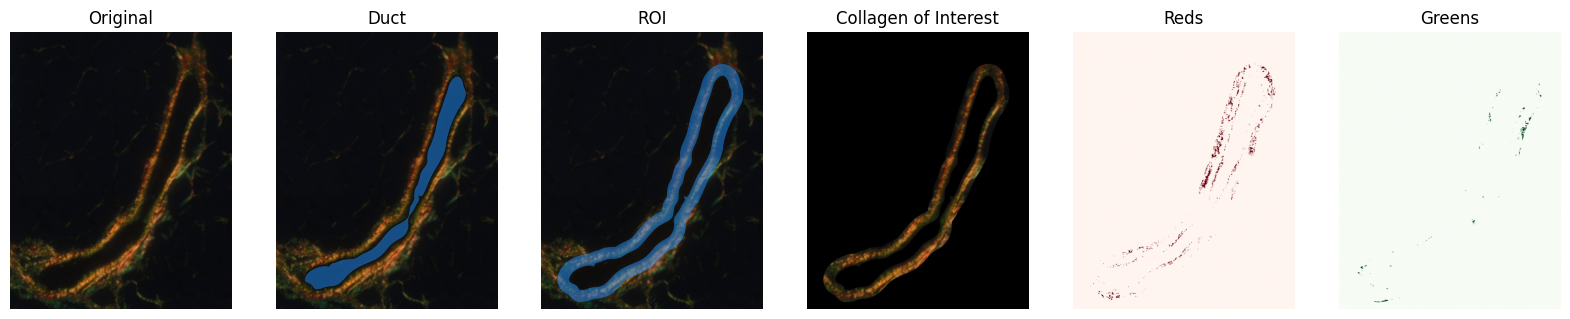

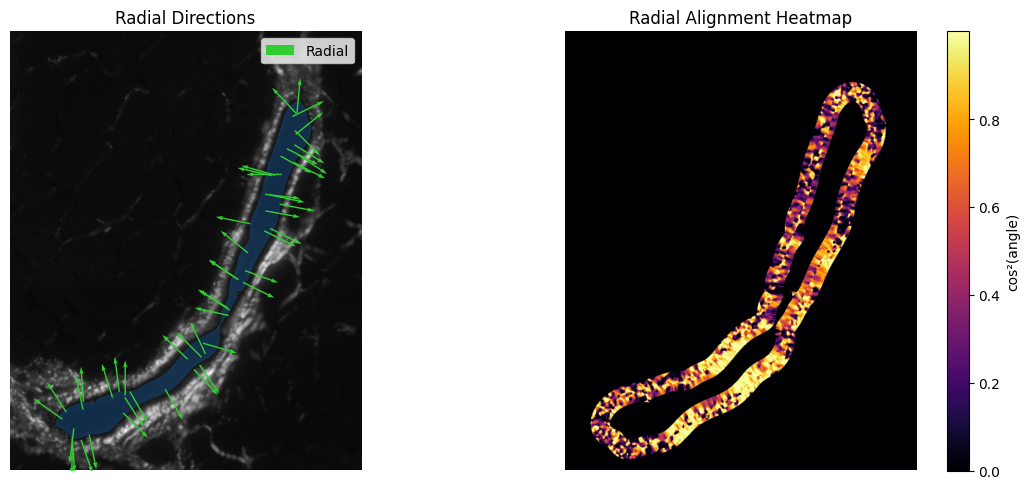

In [29]:
plot_outputs(original_image, ring_mask, collagen_of_interest, smoothed_duct, red_mask, green_mask, x_coords, y_coords, rx, ry, sample_idx, alignment_map)
